# 期权策略在黑天鹅事件下的盈利能力

## 项目背景

今年突然爆发的新冠病毒疫情，作为一次百年难遇的黑天鹅事件，对国内外的股票市场都产生了巨大冲击。2月3日，即今年年后A股的第一个开盘交易日，沪指下跌7.72%，深指下跌8.45%，创业板下跌6.85%。三月份，疫情蔓延到欧美，导致道琼斯指数3月跌幅达13.74%，标普500指数3月跌幅达12.51%，均创下自2008年金融危机以来的最大月度跌幅。

然而，有人忧愁，就有人欢喜。截止到3月末，美国一家名为Universa Investments的对冲基金公司的年内收益率为4144%，其中仅三月份回报率就高达3612%。而这家公司的一位合伙人，正是“黑天鹅之父”--纳西姆 塔勒布。塔勒布先生认为黑天鹅事件无法预测，只能预防，因此其投资理念就是绝不承担没有下限的风险，同时在波动率巨大的行情中寻觅获利的商机。而实现其投资理念的一款绝佳金融产品，就是期权。

基于此，本项目选取国内市场的期权数据，构建带有强保护能力的对冲交易策略，不仅分析其在当前疫情环境下的避险价值，更会探究其在长期市场中的盈利能力。

## 项目要求

一、期权及相关数据的获取与整理

二、构建期权对冲交易策略

三、期望假设回归分析

四、稳健性检验

## 具体步骤

### 一、期权及相关数据的获取与整理

#### 获取期权合约数据，转换日期的时间格式，并删除不相关期权合约的数据

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve

options = pd.read_excel('china_options.xlsx',index_col=0)
options = options[options.index<2276]
t1 = []
for i in options.maturity_date:
    t1.append(str(i))
t2 = []
for i in options.list_date:
    t2.append(str(i))
options.maturity_date = pd.to_datetime(t1)
options.list_date = pd.to_datetime(t2)

### 保留2020年6月之前到期，且存续期大于30天的期权合约

In [4]:
options['duration'] = ((options.maturity_date - options.list_date).map(lambda x:x.days))
options = options[options.duration>30]
options = options[options.maturity_date<'2020-06-01']

#### 删除多余列：'name','exercise_type','kind','list_date','list_price'

In [5]:
options.drop(['name','exercise_type','list_date','list_price'],axis=1,inplace=True)
options

,ts_code,call_put,exercise_price,maturity_date,duration
0,10000579.SH,C,2.150,2016-04-27,62
1,10000108.SH,C,2.650,2015-05-27,62
2,10000111.SH,P,2.550,2015-05-27,62
3,10001067.SH,C,3.240,2017-12-27,34
4,10001068.SH,P,3.240,2017-12-27,34
5,10001069.SH,C,3.240,2018-03-28,125
6,10001070.SH,P,3.240,2018-03-28,125
7,10001071.SH,C,3.240,2018-06-27,216
8,10001072.SH,P,3.240,2018-06-27,216
9,10001073.SH,C,2.896,2018-01-24,62


#### 生成一个新的options列表，列表中每个元素用以储存每个到期日的所有期权合约

In [6]:
MT = options.maturity_date.value_counts().sort_index().index

In [7]:
option = []
for i in MT:
    option.append(options[options.maturity_date == i])
# 将每个到期日的期权DataFrame存进列表，每个元素是一个DataFrame
    
for i in option:
    i.index = range(len(i))
# 每个DataFrame内index设置为1-len（）

#### 获取期权合约在每月最后一个交易日与到期日的价格数据

In [8]:
option1 = pd.read_excel('option1.xlsx',index_col=0)
t1 = []
for i in option1.trade_date:
    t1.append(str(i))
option1.trade_date = pd.to_datetime(t1)

option2 =pd.read_excel('option2.xlsx',index_col=0)
t1 = []
for i in option2.trade_date:
    t1.append(str(i))
option2.trade_date = pd.to_datetime(t1)
option1.columns = ['ts_code','trade_date','trade_close']
option2.columns = ['ts_code','maturity_date','maturity_close']
option1.trade_close

0      0.1656
1      0.0488
2      0.2488
3      0.0108
4      0.0060
5      0.0906
6      0.2722
7      0.0316
8      0.0194
9      0.2270
10     0.1870
11     0.1518
12     0.2080
13     0.1202
14     0.0199
15     0.1232
16     0.0459
17     0.0294
18     0.0720
19     0.0915
20     0.2449
21     0.2212
22     0.3074
23     0.2755
24     0.1093
25     0.3574
26     0.0416
27     0.0576
28     0.1054
29     0.1293
        ...  
234    0.0691
235    0.0541
236    0.0421
237    0.0585
238    0.0748
239    0.0931
240    0.1159
241    0.1402
242    0.1693
243    0.2016
244    0.2383
245    0.2736
246    0.3981
247    0.3196
248    0.2532
249    0.1921
250    0.1432
251    0.1046
252    0.0730
253    0.0520
254    0.0359
255    0.0545
256    0.0771
257    0.1085
258    0.1490
259    0.2006
260    0.2612
261    0.3311
262    0.4069
263    0.4895
Name: trade_close, Length: 7490, dtype: float64

#### 获取标的资产价格数据与无风险利率数据

In [9]:
bond = pd.read_excel('中国一年期国债历史收益率.xlsx')
ss50 = pd.read_excel('50ETF.xlsx',sheet_name=0)
ss50_MT = pd.read_excel('50ETF.xlsx',sheet_name=1)
ss50_FT = ss50[-63:-1]
ss50_FT.index = range(len(ss50_FT))
t1= []
for i in ss50_MT['时间']:
    t1.append(str(i))
ss50_MT['时间'] = pd.to_datetime(t1)

#### 计算波动率，并合并数据

In [10]:
#historical_vol = np.std(np.log(stock_prices[2]/stock_prices[3])) * np.sqrt(12)
vol = []
for i in range(-63,-1):
    vol.append((ss50[i-12:i]['涨跌幅']/100).std() * np.sqrt(12))

In [11]:
for i in range(len(option)):
    option[i]['trade_date'] = ss50_FT['时间'][i] 
    option[i]['spot_price'] = ss50_FT['收盘价'][i]
    option[i]['ttm'] = ((option[i].maturity_date - option[i].trade_date).map(lambda x:x.days))/365
    option[i]['rf'] = bond['收盘'][i] 
    option[i]['vol'] = vol[i]
    option[i]['stock_price'] = ss50_MT['收盘价'][i] 
    option[i] = pd.merge(option[i],option1,on = ['trade_date','ts_code'],how = 'inner')
    option[i] = option[i].drop(['maturity_date','trade_date'],axis = 1)
    option[i] = option[i].sort_values(['exercise_price'])
    option[i].index = range(len(option[i]))


KeyError: 62

In [12]:
option[0]

,ts_code,call_put,exercise_price,duration,spot_price,ttm,rf,vol,stock_price,trade_close
0,10000001.SH,C,2.20,44,2.438,0.071233,0.0319,0.374419,2.604,0.2488
1,10000006.SH,P,2.20,44,2.438,0.071233,0.0319,0.374419,2.604,0.0060
2,10000007.SH,P,2.25,44,2.438,0.071233,0.0319,0.374419,2.604,0.0108
3,10000002.SH,C,2.25,44,2.438,0.071233,0.0319,0.374419,2.604,0.2080
4,10000008.SH,P,2.30,44,2.438,0.071233,0.0319,0.374419,2.604,0.0194
5,10000003.SH,C,2.30,44,2.438,0.071233,0.0319,0.374419,2.604,0.1656
6,10000004.SH,C,2.35,44,2.438,0.071233,0.0319,0.374419,2.604,0.1232
7,10000009.SH,P,2.35,44,2.438,0.071233,0.0319,0.374419,2.604,0.0316
8,10000010.SH,P,2.40,44,2.438,0.071233,0.0319,0.374419,2.604,0.0488
9,10000005.SH,C,2.40,44,2.438,0.071233,0.0319,0.374419,2.604,0.0906


### 二. 构建期权对冲交易策略

* 策略逻辑：自上证50ETF期权上市交易开始，上个月的最后一个交易日建仓，如果当日期权的平均隐含波动率小于历史波动率，说明期权合约整体被低估，那么就构建牛市价差策略，买入行权价较低的期权并卖出行权价较高的期权。否则，构建熊市价差策略。每个月的到期日平仓，交割所有到期的期权合约

#### 计算隐含波动率

In [16]:
def black_scholes_call_pricing(K,T,S0,r,vol):
    d1 = (np.log(S0/K) + (r+0.5*vol*vol)*T)/(vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    C = S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    return np.round(C,4)

def black_scholes_put_pricing(K,T,S0,r,vol):
    d1 = (np.log(S0/K) + (r+0.5*vol*vol)*T)/(vol*np.sqrt(T))
    d2 = d1 - vol*np.sqrt(T)
    P = -S0 * norm.cdf(-d1) + K * np.exp(-r*T) * norm.cdf(-d2)
    return np.round(P,4)

def calloption_implied_volatility(call_price,K,T,S0,r):
    def toSolve(vol): 
        return black_scholes_call_pricing(K,T,S0,r,vol) - call_price
    vol = fsolve(toSolve,1) # 稍后了解一下fsolve的用法
    return np.round(vol[0],4)

def putoption_implied_volatility(put_price,K,T,S0,r):
    def toSolve(vol):
        return black_scholes_put_pricing(K,T,S0,r,vol) - put_price
    vol = fsolve(toSolve,1)
    return np.round(vol[0],4)
type(option[0])

pandas.core.frame.DataFrame

In [17]:
for i in option:
    iv = []
    for j in range(len(i)):
        x = i.loc[j]
        if x.call_put == 'C':
            iv.append(calloption_implied_volatility(x.trade_close,x.exercise_price,x.ttm,x.spot_price,x.rf))
        else:
            iv.append(putoption_implied_volatility(x.trade_close,x.exercise_price,x.ttm,x.spot_price,x.rf))
    i['implied_vol'] = iv


AttributeError: 'Series' object has no attribute 'trade_close'

In [31]:
option[10]['ttm']

0     0.073973
1     0.073973
2     0.073973
3     0.073973
4     0.073973
5     0.073973
6     0.073973
7     0.073973
8     0.073973
9     0.073973
10    0.073973
11    0.073973
12    0.073973
13    0.073973
14    0.073973
15    0.073973
16    0.073973
17    0.073973
Name: ttm, dtype: float64

#### 构建模型

In [32]:
ret_cat = []
for i in option:
    if i.implied_vol.mean() < i.vol.iloc[0] :# implied_vol是在建仓日算出的，每月有一个，对每种期权相同
        buy = i[:int((len(i)+1)/2)]
        sell = i[int((len(i)+1)/2):]
        buy_cost = buy.trade_close.sum()
        sell_payoff = sell.trade_close.sum()
        buy_payoff = np.maximum(buy[buy.call_put == 'C'].stock_price-buy[buy.call_put == 'C'].exercise_price,0).sum()+np.maximum(buy[buy.call_put == 'P'].exercise_price-buy[buy.call_put == 'P'].stock_price,0).sum()
        sell_cost = np.maximum(sell[sell.call_put =='C'].stock_price-sell[sell.call_put == 'C'].exercise_price,0).sum() +np.maximum(sell[sell.call_put == 'P'].exercise_price-sell[sell.call_put == 'P'].stock_price,0).sum()
        cost = buy_cost + sell_cost
        payoff = buy_payoff + sell_payoff
        returns = (payoff - cost)/cost
    else:
        buy = i[int((len(i)+1)/2):]
        sell = i[:int((len(i)+1)/2)]
        buy_cost = buy.trade_close.sum()
        sell_payoff = sell.trade_close.sum()
        buy_payoff = np.maximum(buy[buy.call_put == 'C'].stock_price-buy[buy.call_put == 'C'].exercise_price,0).sum()+np.maximum(buy[buy.call_put == 'P'].exercise_price-buy[buy.call_put == 'P'].stock_price,0).sum()
        sell_cost = np.maximum(sell[sell.call_put == 'C'].stock_price-sell[sell.call_put == 'C'].exercise_price,0).sum() +np.maximum(sell[sell.call_put == 'P'].exercise_price-sell[sell.call_put == 'P'].stock_price,0).sum()
        cost = buy_cost + sell_cost
        payoff = buy_payoff + sell_payoff
        returns = (payoff - cost)/cost
        ret_cat.append(returns)
        

KeyError: 'implied_vol'

#### 作图展示策略当期收益率，并与上证50ETF基金的同期收益率作比较

ValueError: x and y must have same first dimension, but have shapes (63,) and (62,)

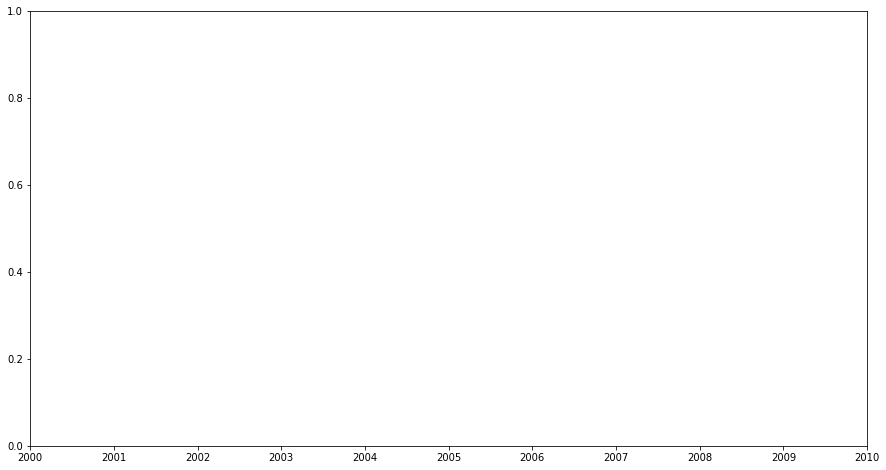

In [33]:
plt.figure(figsize = (15,8))
fund_profit = (ss50_MT['收盘价'] - ss50_FT['收盘价'])/ss50_FT['收盘价']
plt.plot(MT,fund_profit,'r',label = "fund returns",linewidth=2,marker='o',markersize=10)
plt.plot(MT,ret_cat,'b',label = "option strategy returns",linewidth=2,marker='o',markersize=10)
plt.xlabel('years',fontsize=20)
plt.ylabel('returns',fontsize=20)
plt.xticks(fonsize=16)
plt.yticks(fontsize=16)
plt.legend(['fund returns','option strategy returns'],fontsize=16)
plt.grid()
plt.show()

#### 作图展示策略累积收益率，并与上证50ETF基金的同期收益率作比较

### 三、期望假设回归分析 

#### 对当期收益率进行期望假设回归分析

#### 对到期收益率进行期望假设回归分析

### 四、稳健性检验

#### 将原样本option划分为两个子样本，并分析每个子样本时间段的盈利能力